# **Data understanding & Explorasi Data**

## **Data Understanding**

Data Understanding adalah proses mendalami data: struktur, sumber, kualitas, distribusi, dan keterbatasannya. Tujuannya memastikan data layak dipakai untuk analisis & modelling.

1. Langkah-langkah Umum

* Ingest & sampling — ambil sample dataset (mis. 1k baris) untuk eksplorasi awal.

* Profiling — statistik dasar: count, unique, min/max, mean, std, percentiles.

* Visualisasi awal — hist, boxplot, scatter untuk deteksi pola & outlier.

* Quality checks — missing, duplicates, inconsistent formats, range checks.

* Data dictionary / metadata — jelaskan tiap kolom: tipe, allowed values, deskripsi.

* Lineage & source validation — darimana data? apakah ETL mengubahnya?

* Privacy & compliance — PII handling, GDPR/PDPA bila relevan.

2. Dimensi Kualitas Data (detail)

  * Completeness (kelengkapan): ada missing/null?

  * Accuracy (ketepatan): apakah nilai mewakili kenyataan? (sulit verifikasi tanpa sumber eksternal)

  * Consistency (konsistensi): format kolom konsisten (tanggal, kode pos), business rules konsisten (ShipDate >= OrderDate)

  * Uniqueness: duplicate transactions / order IDs

  * Validity: apakah nilai di domain yang valid (mis. Segment ∈ {Consumer, Corporate, Home Office})

  * Timeliness: data up-to-date sesuai kebutuhan analisis

  * Integrity / Referential: relasi antar tabel (jika ada) valid

3. Data Dictionary (contoh ringkas untuk Superstore)

  * *Order ID* — string, unik per order (mis. CA-2018-...)

  * *Order Date* — date, format (YYYY-MM-DD)

  * *Ship Date* — date

  * *Ship Mode* — categorical (First Class, Second Class, Standard Class, Same Day)

  * *Sales* — numeric (float), total sale amount

  * *Quantity* — integer

  * *Discount* — numeric (0.0 - 1.0) biasanya percent

  * *Profit* — numeric (float)
4. Praktik EDA & Pemeriksaan Kualitas

In [21]:
# 1. Install library

!pip install python-dotenv psycopg2-binary pandas seaborn matplotlib

import psycopg2
from psycopg2.extras import execute_values
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


Penjelasan:

* *python-dotenv* → membaca file *.env* yang berisi kredensial database.

* *psycopg2-binary* → driver untuk koneksi Python ke PostgreSQL (termasuk Supabase).

* *pandas* → manipulasi data, membaca CSV.

* *matplotlib* dan *seaborn* → visualisasi data (grafik).

In [22]:
# 2. Buat file .env (isi dengan kredensial Supabase Anda)

with open(".env", "w") as f:
    f.write("""user=postgres
    password=ks9unws6dHe76WJD
    host=aws-1-us-east-2.pooler.supabase.com
    port=6543
    dbname=postgres
    """)


Penjelasan:

* *.env* menyimpan informasi login Supabase secara aman.

* Supabase default pakai user *postgres*.

In [ ]:
# 3. Load environment variables dari .env

load_dotenv()

USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")


Penjelasan:

* *load_dotenv()* → membaca isi file .env.

* *os.getenv("user")* → mengambil variabel *user* dari *.env*.

In [ ]:
# 4. Connect ke Supabase PostgreSQL
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("✅ Connection successful!")
    connection.close()
except Exception as e:
    print("❌ Failed to connect:", e)


Penjelasan:

* Membuka koneksi ke Supabase.

* Kalau berhasil → print “✅ Connection successful!”.

* Kalau gagal (misal password salah, Supabase mati) → print error.

In [ ]:
# 5. Buat tabel superstore (jika belum ada)

create_table_query = """
CREATE TABLE IF NOT EXISTS superstore (
    "OrderID" VARCHAR(50),
    "OrderDate" DATE,
    "ShipDate" DATE,
    "ShipMode" VARCHAR(50),
    "CustomerID" VARCHAR(50),
    "CustomerName" VARCHAR(100),
    "Segment" VARCHAR(50),
    "Country" VARCHAR(50),
    "City" VARCHAR(50),
    "State" VARCHAR(50),
    "PostalCode" VARCHAR(20),
    "Region" VARCHAR(50),
    "ProductID" VARCHAR(50),
    "Category" VARCHAR(50),
    "SubCategory" VARCHAR(50),
    "ProductName" TEXT,
    "Sales" FLOAT,
    "Quantity" INT,
    "Discount" FLOAT,
    "Profit" FLOAT
);
"""


Penjelasan:

* Membuat tabel PostgreSQL bernama superstore.

* Disesuaikan dengan kolom yang ada di *Sample - Superstore.csv*.

In [23]:
# 6. Load CSV (ubah path ke file Anda di Colab)

csv_file_path = "/content/Sample - Superstore.csv"

try:
    df = pd.read_csv(csv_file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding="latin1")

df = df.fillna("")
df["Order Date"] = pd.to_datetime(df["Order Date"]).dt.date
df["Ship Date"] = pd.to_datetime(df["Ship Date"]).dt.date

print("✅ CSV loaded, sample:")
print(df.head())


✅ CSV loaded, sample:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688  2016-06-12  2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  

Penjelasan:

* Membaca file CSV.

* Kalau gagal baca dengan UTF-8, coba latin1 (*umum di Windows/Excel*).

* Convert tanggal ke format *DATE*.

* Ganti nilai kosong (*NaN*) dengan string kosong.

In [ ]:
# 7. Bulk insert data ke Supabase

records = [
    (
        row["Order ID"], row["Order Date"], row["Ship Date"], row["Ship Mode"],
        row["Customer ID"], row["Customer Name"], row["Segment"], row["Country"],
        row["City"], row["State"], str(row["Postal Code"]), row["Region"], row["Product ID"],
        row["Category"], row["Sub-Category"], row["Product Name"], row["Sales"],
        int(row["Quantity"]), row["Discount"], row["Profit"]
    )
    for _, row in df.iterrows()
]


Penjelasan:

* Mengubah dataframe *df* jadi list of tuples untuk dimasukkan ke database.

* *execute_values* akan menyisipkan data dalam jumlah banyak sekaligus (bulk insert → lebih cepat).

In [ ]:
# 8. Cek jumlah baris & sample data dari Supabase

try:
    connection = psycopg2.connect(
        user=USER, password=PASSWORD, host=HOST, port=PORT, dbname=DBNAME
    )
    cursor = connection.cursor()

    cursor.execute("SELECT COUNT(*) FROM superstore;")
    total_rows = cursor.fetchone()[0]
    print(f"📊 Total rows in superstore: {total_rows}")

    cursor.execute("SELECT * FROM superstore LIMIT 5;")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

    cursor.close()
    connection.close()
except Exception as e:
    print("❌ Error check data:", e)


Penjelasan:

* Mengecek apakah data sudah masuk ke Supabase.

* Print jumlah total baris.

* Menampilkan 5 baris pertama sebagai sample.

## **Explorasi Data**

In [24]:
print("\n📌 Tipe data kolom:")
print(df.dtypes)



📌 Tipe data kolom:
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object


In [14]:
# Import library untuk Visualisasi

import matplotlib.pyplot as plt
import seaborn as sns

Penjelasan:

  * *matplotlib.pyplot* → digunakan untuk membuat grafik dasar (bar, line, scatter).

  * *seaborn* → library untuk visualisasi yang lebih cantik, mendukung heatmap, boxplot, dll.

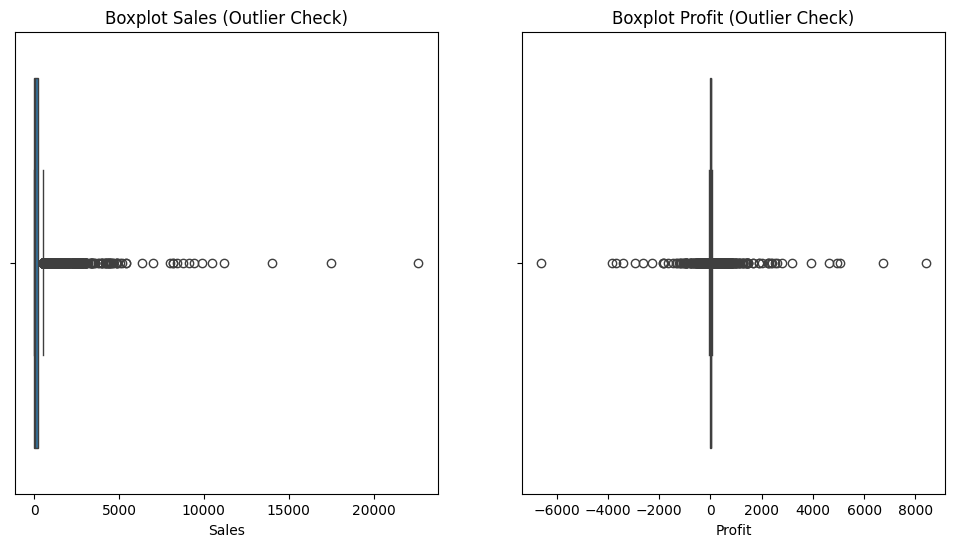

In [15]:
# a. Distribusi Sales dan Profit (boxplot untuk outlier)

plt.figure(figsize=(12,6))

# Boxplot Sales
plt.subplot(1,2,1)
sns.boxplot(x=df["Sales"])
plt.title("Boxplot Sales (Outlier Check)")

# Boxplot Profit
plt.subplot(1,2,2)
sns.boxplot(x=df["Profit"])
plt.title("Boxplot Profit (Outlier Check)")

plt.show()

Penjelasan:

  * Boxplot menampilkan median, Q1, Q3, whisker, dan outlier.

  * Dari grafik ini bisa dilihat apakah Sales atau Profit punya nilai ekstrim (outlier).

  * Outlier akan muncul sebagai titik yang jauh dari box.

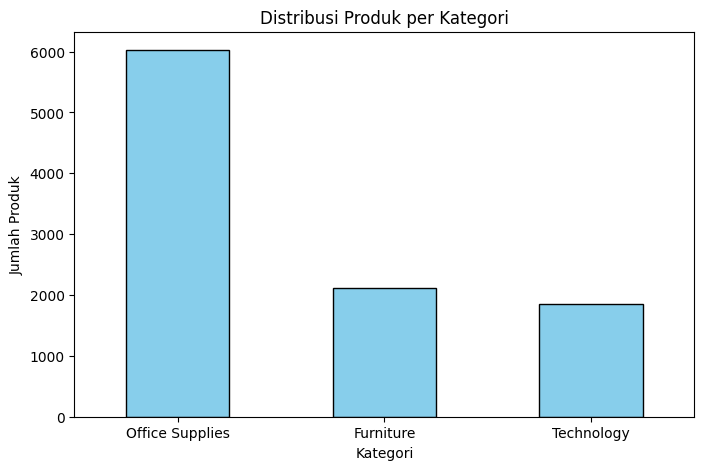

In [16]:
# b. Distribusi kategori produk

plt.figure(figsize=(8,5))
df["Category"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribusi Produk per Kategori")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Produk")
plt.xticks(rotation=0)
plt.show()

Penjelasan:

  * value_counts() → menghitung jumlah data per kategori.

  * Grafik ini membantu melihat kategori produk mana yang paling banyak (misal: Office Supplies biasanya paling banyak).

  * Bagus untuk analisis strategi penjualan per kategori.

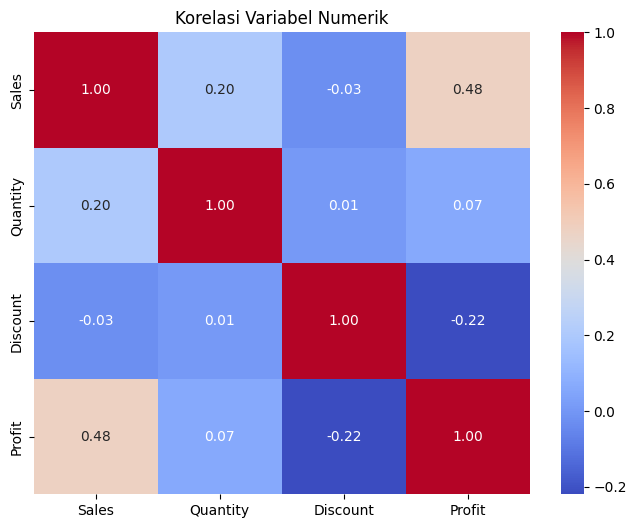

In [17]:
# c. Korelasi numerik

plt.figure(figsize=(8,6))
sns.heatmap(df[["Sales","Quantity","Discount","Profit"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi Variabel Numerik")
plt.show()

In [20]:
# -------------------------
# d. Missing values (dengan pengecekan)
# -------------------------
missing = df.isnull().sum()
missing = missing[missing > 0]  # hanya tampilkan kolom dengan NaN

if missing.empty:
    print("✅ Tidak ada missing values pada dataset")
else:
    plt.figure(figsize=(10,4))
    missing.plot(kind="bar", color="salmon", edgecolor="black")
    plt.title("Missing Values per Kolom")
    plt.ylabel("Jumlah Missing")
    plt.show()


✅ Tidak ada missing values pada dataset
